In [1]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
#from nistats.first_level_model import FirstLevelModel
#from nistats.second_level_model import SecondLevelModel
#from nistats.thresholding import map_threshold
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl
from plotting_utils import *

# t1w background image template
# mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
mni09c = '/home/scotti/projects/3t_7t_sst_comparison/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

/tmp/ipykernel_2728058/2499221329.py:1: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  import nistats
/home/scotti/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
Matplotlib is building the font cache; this may take a moment.


In [2]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', model_n=0, thresholding=None, threshold_z=3.1, hp=False,
                          base_dir='../derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst',
                          from_working_dir=False, 
                          flame='1'):
    
    # Look-up dictionaries
    if model_n == 0:
        first_level_copes = {'fs': 0,
                             'ss': 1,
                             'go': 2,
                             'fs-go': 3,
                             'fs-ss': 4,
                             'ss-go': 5
                             }

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    elif model_n == 1:
        first_level_copes = {'response_left': 0,
                             'response_right': 1,
                             'left-right': 2}

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]
    
    if hp:
        model_suffix = '_hp'
    else:
        model_suffix = ''

    if thresholding is None or thresholding == 'fdr':
        if from_working_dir:
            nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_sstmsit_hp/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_flame{flame}/flameo/stats/zstat{cope2}.nii.gz')
        else:
            nii = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat.nii.gz'))
        
        if thresholding is None:
            threshold = 0
        else:
            _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')
            
    elif thresholding == 'fwer' or thresholding == 'cluster':
        
        # if from_working_dir:
        #     nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_{run_mode}/flameo/stats/zstat{cope2}.nii.gz')        
        nii_pos = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))
        nii_neg = nib.load(os.path.join(base_dir, f'model-{model_n}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2+1}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))

        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nii_pos.get_fdata())
        

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1.3])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction=display_mode, n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

# Leipzig_7T_SM

In [4]:
dataset = 'Leipzig_7T_SM'
base_dir = f'../derivatives/glm_feat_hp_sct/group_level_model/{dataset}'
fwhm = '1p6'

# MOTOR

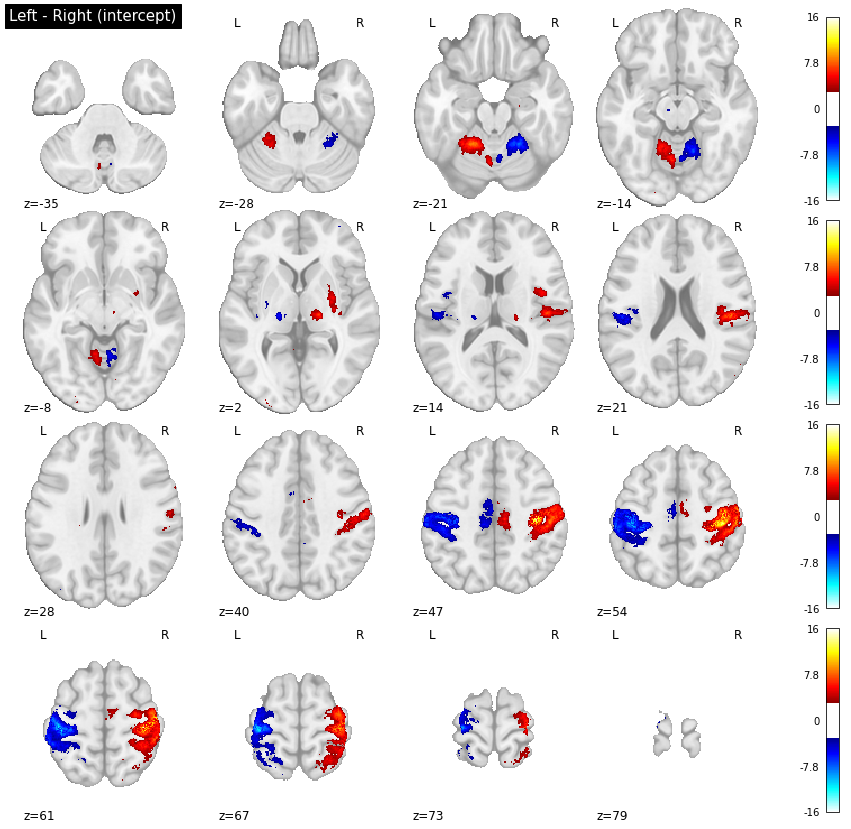

In [9]:
z_map_responselr_intercept, threshold = get_second_level_zmap('left-right', 'intercept', fwhm=fwhm, thresholding='fdr',model_n=1,from_working_dir=False, base_dir=base_dir, flame='12')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, bg_img=mni09c, title='Left - Right (intercept)', black_bg=False)

## FS-Go

In [3]:
fs_go_intercept, threshold = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
f, ax = plot_4x4(fs_go_intercept, display_mode='y', threshold=threshold, bg_img=mni09c, title='FS - Go (intercept)', black_bg=False)

NameError: name 'fwhm' is not defined

# FS - SS

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.316194534301758. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:373: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


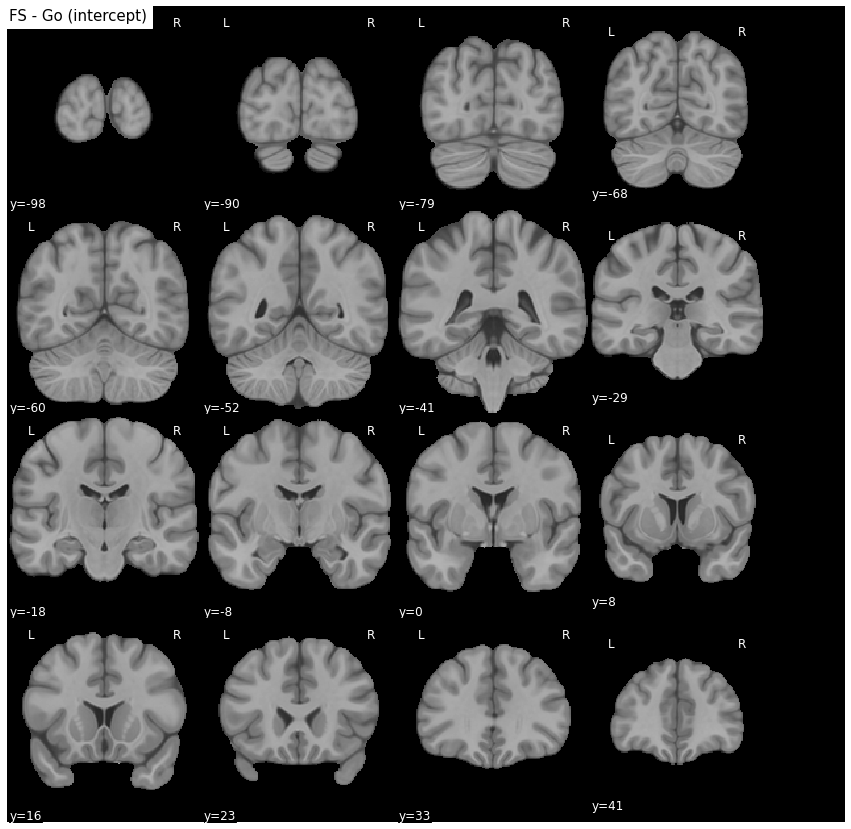

In [6]:
fs_ss_intercept, threshold = get_second_level_zmap('fs-ss', 'intercept', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
f, ax = plot_4x4(fs_ss_intercept, display_mode='y', threshold=threshold, bg_img=mni09c, title='FS - SS (intercept)')

# SS - GO

In [ ]:
ss_go_intercept, threshold = get_second_level_zmap('ss-go', 'intercept', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
f, ax = plot_4x4(ss-go_intercept, display_mode='y', threshold=threshold, bg_img=mni09c, title='SS - Go (intercept)')

# PLOT ALL CONTRAST

In [3]:
base_dir = f'../derivatives/glm_feat_hp_sct/group_level_model/Leipzig_7T_SM'
fwhm = 'base'

# Load MNI template
# Make background colour black
mni09c_load = nib.load(mni09c)
black_bg = mni09c_load.get_data()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=mni09c_load.affine)

fsgo, fsgo_thresh = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm, thresholding=None,model_n=0,from_working_dir=False, base_dir=base_dir, flame='12')
fsss, fsss_thresh = get_second_level_zmap('fs-ss', 'intercept', fwhm=fwhm, thresholding=None,model_n=0,from_working_dir=False, base_dir=base_dir, flame='12')
ssgo, ssgo_thresh = get_second_level_zmap('ss-go', 'intercept', fwhm=fwhm, thresholding=None,model_n=0,from_working_dir=False, base_dir=base_dir, flame='12')

zmaps = [fsgo, fsss, ssgo]
threshs = [fsgo_thresh, fsss_thresh, ssgo_thresh]

/tmp/ipykernel_2728058/741222555.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  black_bg = mni09c_load.get_data()


/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

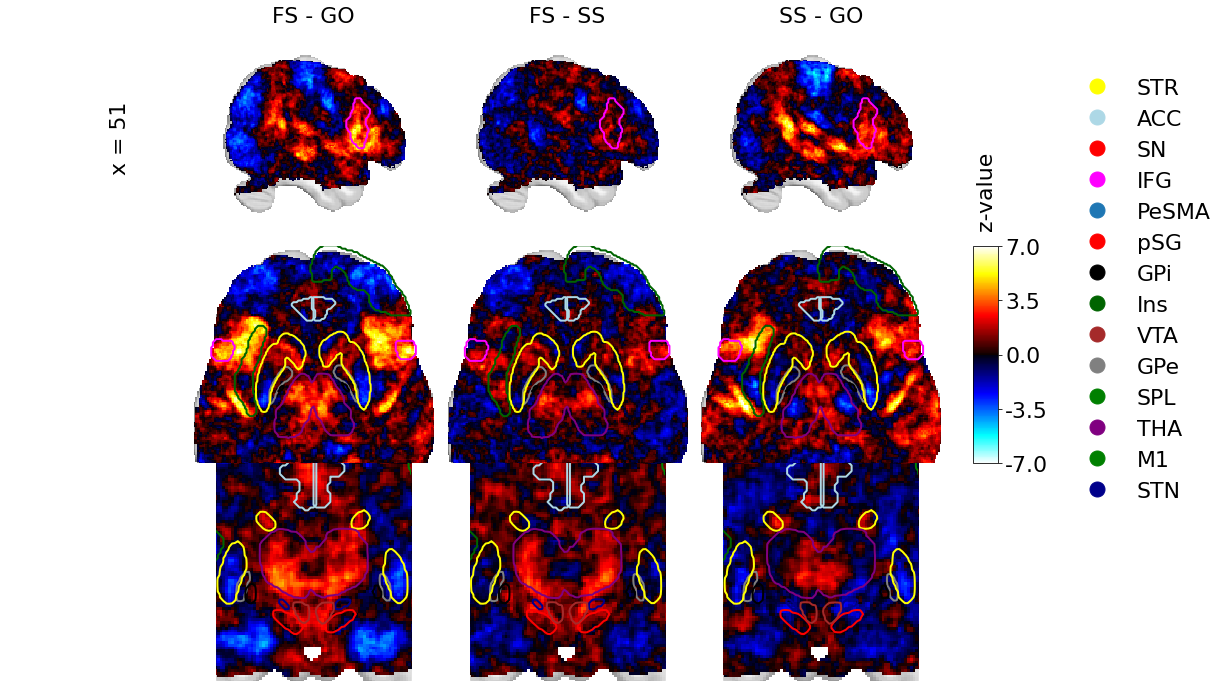

In [9]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=threshs,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('FS - GO')
axes[0,1].set_title('FS - SS')
axes[0,2].set_title('SS - GO')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

In [13]:
fm = matplotlib.font_manager
fm._get_fontconfig_fonts.cache_clear()

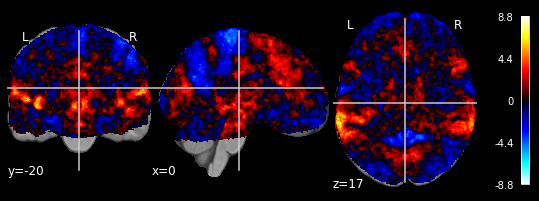

In [4]:
plotting.plot_stat_map(fsgo, bg_img=mni09c)

/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


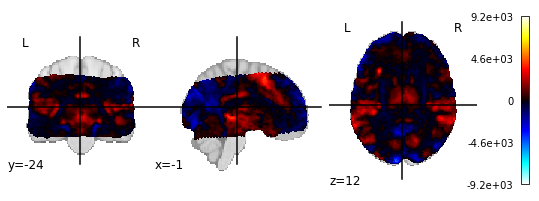

In [5]:
plotting.plot_stat_map('/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/group_level_model/Leipzig_7T_GdH/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-0_grouplevelcontrast-1_flame-12_desc-cope.nii.gz')

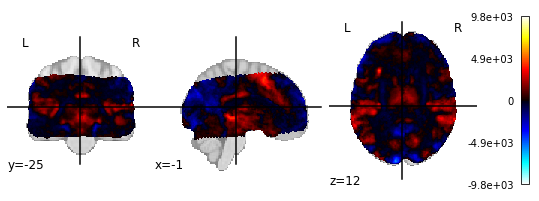

In [6]:
plotting.plot_stat_map('/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/group_level_model/Leipzig_7T_GdH/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-0_grouplevelcontrast-1_flame-1_desc-cope.nii.gz')